In [ ]:
#|default_exp layouts

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export

import itertools
import math
import operator
from abc import ABC, abstractmethod
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path
from pprint import pprint
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import rasterfairy
from pointgrid import align_points_to_grid
from rasterfairy import coonswarp
from scipy.stats import gaussian_kde
from sklearn.preprocessing import minmax_scale

from clip_plot.configuration import UmapSpec
from clip_plot.images import ImageFactory
from clip_plot.reducers import get_single_reducer_xy
from clip_plot.utils import get_json_path, read_json, round_floats, timestamp, write_json


## Set some constants we want to remove later

## Layouts and their inputs

It's useful to think of layouts and the required data to generate them:

### No data:

- alphabetical layout
    - Only requires the total amount of images to generate the layout  

### Embeddings:

- umap layout
    - Uses embeddings (vecs) to generate layout
    - Under some circumstances it will uses metadata (labels)
- rasterfairy
    - uses umap layout

### Metadata:
- categorical layout
    - uses "category" data from metadata
- date layout
    - uses "date" data from metadata
- custom layout
    - uses "x" & "y" data from metadata
- geographic layout: dropped for now

## Layouts and their outputs

It's useful to think of layouts and how they output their data (to be consumed by the web application)

All layouts output a .json composed of list of list as follows:
<blockquote>
[<br>
    [<br>
        x, # x-coordinate of 1st image<br> 
        y # y-coordinate of 1st image<br>
    ],<br>
    [<br>
        x, # x-coordinate of 2nd image<br> 
        y # y-coordinate of 2nd image<br>
    ],<br>
    . . . ,<br>
]
</blockquote>

Some layouts will also output a label file specifying labels and their position:
  - Category layouts
  - Date layouts (named "timeline-{plot_id}.json" and "timeline-labels-{plot_id}.json")  
  
All layouts (and their label file if applicable) are specified in the manifest.json  <br>

The umap layout is unique in the cense that you can create "variants" by specifying more than one n_neighbors and/or min_dist.  
Clip-plot will generate len(n_neighbors) * len(min_dist) number of variants:  
  - E.g. n_neighbors=[7,15] and min_dist=[.005, .001] will generate 2*2=4 variants  

Each variant is saved as its own file (e.g. "umap-n_neighbors_{n_neighbors_}-min_dist_{min_dist}-{plot_id}.json")  
In addition, each variant (even if there is only one), will have a jittered file saved as well

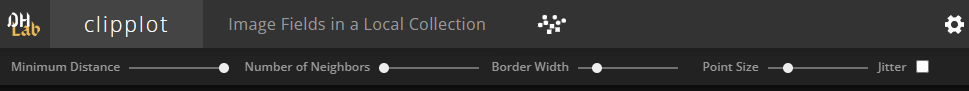

# Create layouts (dimensionality reduction, other)

In [ ]:
#| export

def normalize_layout(obj: Any, scale: bool = True, round: bool = True):
    """
    Write layout json `obj` to disk and return the path to the saved file
    """
    if scale:
        # scale -1:1
        obj = (minmax_scale(obj) - 0.5) * 2
    if round:
        obj = round_floats(obj)
    if isinstance(obj, np.ndarray):
        obj = obj.tolist()
    return obj


In [ ]:
#| export

def write_layout(output_path: Path, data_dir: Path,
                 obj: Any, scale: bool = True, round: bool = True):
    """
    Normalize layout, then write to disk and
    return path relative to data dir
    """
    obj = normalize_layout(obj, scale, round)
    return write_json(output_path=output_path, data_dir=data_dir, obj=obj)

In [ ]:
#| export

class BaseLayout(ABC):
    # Hardcoded for each particular layout
    # User should change
    _SCALE = True
    _ROUND = True
    _SUBDIR = "layouts"
    _FILENAME = ""
    _ADD_HASH = True

    def __init__(self, plot_id: str, data_dir: Path):
        self.plot_id = plot_id
        self.data_dir = data_dir

    @abstractmethod
    def get_layout(self):
        # Get or create layout
        pass


class BaseMetaLayout(BaseLayout):
    def __init__(self, plot_id, imageEngine) -> None:
        super().__init__(plot_id, imageEngine.data_dir)
        self.imageEngine = imageEngine

class AlphabeticLayout(BaseMetaLayout):
    _SUBDIR = "layouts"
    _FILENAME = "grid"

    def get_layout(self):
        """
        Get the x,y positions of images in a grid projection
        """
        print(timestamp(), "Creating grid layout")
        out_path = get_json_path(self.data_dir, self._SUBDIR, self.plot_id, self._FILENAME)
        n = math.ceil(self.imageEngine.count ** (1 / 2))
        positions = []
        for i in range(self.imageEngine.count):
            x = i % n
            y = math.floor(i / n)
            positions.append([x, y])
        z = np.array(positions)

        write_layout(out_path, self.data_dir, z)
        return out_path

In [ ]:
#| export

@dataclass
class Box:
        n_cells: int
        width: int
        height: int
        x: int | None
        y: int | None

def get_categorical_boxes(group_counts: list[int], margin=2):
    """
    @arg [int] group_counts: counts of the number of images in each
      distinct level within the metadata's categories
    @kwarg int margin: space between boxes in the 2D layout
    @returns [Box] an array of Box() objects, one per level in `group_counts`
    """
    group_counts = sorted(group_counts, reverse=True)
    boxes = []
    for i in group_counts:
        w = h = math.ceil(i ** (1 / 2))
        boxes.append(Box(i, w, h, None, None))
    # find the position along x axis where we want to create a break
    wrap = math.floor(sum([b.n_cells for b in boxes]) ** (1 / 2)) - (2 * margin)
    # find the valid positions on the y axis
    y = margin
    y_spots = []
    for box in boxes:
        if (y + box.height + margin) <= wrap:
            y_spots.append(y)
            y += box.height + margin
        else:
            y_spots.append(y)
            break
    # get a list of lists where sublists contain elements at the same y position
    y_spot_index = 0
    for box in boxes:
        # find the y position
        y = y_spots[y_spot_index]
        # find members with this y position
        row_members = [b.x + b.width for b in boxes if b.y == y]
        # assign the y position
        box.y = y
        y_spot_index = (y_spot_index + 1) % len(y_spots)
        # assign the x position
        box.x = max(row_members) + margin if row_members else margin
    return boxes

def get_categorical_points(boxes: np.ndarray, unit_size=None):
    """Given an array of Box() objects, return a 2D distribution with shape (n_cells, 2)"""
    points_arr = []
    for box in boxes:
        area = box.width * box.height
        per_unit = (area / box.n_cells) ** (1 / 2)
        x_units = math.ceil(box.width / per_unit)
        y_units = math.ceil(box.height / per_unit)
        if not unit_size:
            unit_size = min(box.width / x_units, box.height / y_units)
        for j in range(box.n_cells):
            x = j % x_units
            y = j // x_units
            points_arr.append(
                [
                    box.x + x * unit_size,
                    box.y + y * unit_size,
                ]
            )
    return np.array(points_arr)

In [ ]:
#| export

class CategoricalLayout(BaseMetaLayout):
    _NULL_CATEGORY = "Other"
    _MARGIN = 2
    _FILENAME = "categorical"

    def get_layout(self):
        """
        Return a numpy array with shape (n_points, 2) with the point
        positions of observations in box regions determined by
        each point's category metadata attribute (if applicable)
        """
        if "category" not in self.imageEngine.meta_headers:
            return False

        print(timestamp(), "Creating categorical layout")
        # determine the out path and return from cache if possible
        layout_out_path = get_json_path(self.data_dir, self._SUBDIR,  self.plot_id, self._FILENAME)
        labels_out_path = get_json_path(self.data_dir, self._SUBDIR, self.plot_id, "categorical-labels")

        # accumulate d[category] = [indices of points with category]
        categories = [img.metadata.get("category", None) for img in self.imageEngine]
        if not any(categories) or len(set(categories) - {None}) == 1:
            return False
        d = defaultdict(list)
        for idx, i in enumerate(categories):
            d[i].append(idx)

        # store the number of observations in each group
        keys_and_counts = [{"key": i, "count": len(d[i])} for i in d]
        keys_and_counts.sort(key=operator.itemgetter("count"), reverse=True)
        # get the box layout then subdivide into discrete points
        boxes = get_categorical_boxes([i["count"] for i in keys_and_counts], margin=self._MARGIN)
        points = get_categorical_points(boxes)
        # sort the points into the order of the observations in the metadata
        counts = {i["key"]: 0 for i in keys_and_counts}
        offsets = {i["key"]: 0 for i in keys_and_counts}
        for idx, i in enumerate(keys_and_counts):
            offsets[i["key"]] += sum([j["count"] for j in keys_and_counts[:idx]])
        sorted_points = []
        for img in self.imageEngine:
            category = img.metadata.get("category", self._NULL_CATEGORY)
            sorted_points.append(points[offsets[category] + counts[category]])
            counts[category] += 1
        sorted_points = np.array(sorted_points)
        # add to the sorted points the anchors for the text labels for each group
        text_anchors = np.array([[i.x, i.y - self._MARGIN / 2] for i in boxes])
        # add the anchors to the points - these will be removed after the points are projected
        sorted_points = np.vstack([sorted_points, text_anchors])
        # scale -1:1 using the largest axis as the scaling metric
        _max = np.max(sorted_points)
        for i in range(2):
            _min = np.min(sorted_points[:, i])
            sorted_points[:, i] -= _min
            sorted_points[:, i] /= _max - _min
            sorted_points[:, i] -= np.max(sorted_points[:, i]) / 2
            sorted_points[:, i] *= 2
        # separate out the sorted points and text positions
        text_anchors = sorted_points[-len(text_anchors) :]
        sorted_points = sorted_points[: -len(text_anchors)]
        z = round_floats(sorted_points.tolist())
        write_json(output_path=layout_out_path, data_dir=self.data_dir, obj=z)
        write_json(output_path=labels_out_path,
                   data_dir=self.data_dir,
                   obj={"positions": round_floats(text_anchors.tolist()),
                   "labels": [i["key"] for i in keys_and_counts],},
            )
        return {"layout": layout_out_path,
                "labels": labels_out_path}

In [ ]:
#| export

class CustomLayout(BaseMetaLayout):
    _FILENAME = "custom"

    def __init__(self, x_col: str, y_col: str):
        super().__init__(plot_id, imageEngine.data_dir)
        self.x_col = x_col
        self.y_col = y_col
        self.imageEngine = imageEngine

    def get_layout(self):
        """
        Return a 2D array of image positions corresponding to x,y coordinates in metadata
        """
        out_path = get_json_path(self.data_dir, self._SUBDIR, self.plot_id, self._FILENAME)
        if not self.imageEngine.metadata:
            return
        found_coords = False
        coords = []
        for idx, img in enumerate(self.imageEngine):
            xy = img.metadata.get(self.x_col), img.metadata.get(self.y_col)
            if all(xy):
                found_coords = True
                coords.append(xy)
            else:
                if idx == 0:
                    missing_cols = [sought for found, sought
                                    in zip(xy, [self.x_col, self.y_col])
                                    if not found]
                    print(f"Missing coordinate columns {missing_cols}")
                if found_coords:
                    print(
                        timestamp(),
                        "Some images are missing coordinates; skipping custom layout",
                    )
                    return

        if not found_coords:
            return
        else:
            print(timestamp(), f"Creating custom layout for x:{self.x_col} and y:{self.y_col}")
        coords = np.array(coords).astype(float)
        write_layout(out_path, self.data_dir, obj=coords.tolist())
        return {"layout": out_path}

In [ ]:
#| export

def get_pointgrid_layout(input_path: Path, data_dir: Path, label, plot_id: str):
    """Gridify the positions in `path` and return the path to this new layout"""

    print(timestamp(), f"Creating {label} pointgrid")
    out_path = get_json_path(data_dir=data_dir, subdir="layouts",
                             plot_id=plot_id,
                             filename=f"{label}-jittered",
                             )

    arr = np.array(read_json(input_path))
    if arr.shape[-1] != 2:
        print(timestamp(), "Could not create pointgrid layout because data is not 2D")
        return None

    z = align_points_to_grid(arr, fill=0.05)
    write_layout(out_path, data_dir=data_dir, obj=z)
    return out_path


In [ ]:
#| export

def get_rasterfairy_layout(data_dir: Path, plot_id: str, umap_json_path: Path):
    """Create regular grid layout that keeps umap XYs close to each other"""

    print(timestamp(), "Creating rasterfairy layout")
    out_path = get_json_path(data_dir, "layouts", plot_id, "rasterfairy")
    umap = np.array(read_json(umap_json_path))
    if umap.shape[-1] != 2:
        print(timestamp(), f"Couldn't create rasterfairy layout. Data shape is {umap.shape}, needs to be 2D.")
        return None
    umap = (umap + 1) / 2  # scale 0:1
    try:
        umap = coonswarp.rectifyCloud(
            umap,  # stretch the distribution
            perimeterSubdivisionSteps=4,
            autoPerimeterOffset=False,
            paddingScale=1.05,
        )
    except Exception as exc:
        print(timestamp(), "Coonswarp rectification could not be performed", exc)
    pos = rasterfairy.transformPointCloud2D(umap)[0]
    write_layout(out_path, data_dir=data_dir, obj=pos)
    return out_path

In [ ]:
#| export

def get_umap_layout_or_layouts(hidden_vectors: np.ndarray, imageEngine: ImageFactory, umap_spec: UmapSpec,
                              data_dir: Path, plot_id: str, projector: str = "umap") -> dict[str, list]:
    """Create a multi-layout UMAP projection"""

    print(timestamp(), "Importing UMAP libraries")
    from umap import AlignedUMAP
    umap_variants = []
    for n_neighbors, min_dist in itertools.product(
        umap_spec.n_neighbors, umap_spec.min_dist
    ):
        filename = f"umap-n_neighbors_{n_neighbors}-min_dist_{min_dist}"
        out_path = get_json_path(data_dir, "layouts", plot_id, filename)
        umap_variants.append(
            {
                "n_neighbors": n_neighbors,
                "min_dist": min_dist,
                "filename": filename,
                "out_path": out_path,
            }
        )

    print(timestamp(), "UMAP variants to compute:")
    pprint(umap_variants)

    is_single_layout = len(umap_variants) == 1

    # map each image's index to itself and create one copy of that map for each layout
    relations_dict = {idx: idx for idx, _ in enumerate(hidden_vectors)}

    # determine the subset of umap_variants that have already been computed
    uncomputed_variants = [var for var in umap_variants if not var["out_path"].exists()]

    def _get_label_array(imageEngine: ImageFactory) -> np.ndarray:
        """convert labels to integers"""
        if "label" not in imageEngine.meta_headers:
            return np.array([])
        labels = [img.metadata.get("label", None) for img in imageEngine]
        if not any(labels):
            return np.array([])
        label_to_int = defaultdict(lambda: len(label_to_int))
        label_ints = []
        for label in labels:
            label_ints.append(-1 if label is None else label_to_int[label])
        return np.array(label_ints)
    
    # Labels for fitting if available
    label_array = _get_label_array(imageEngine)

    if is_single_layout:
        print(timestamp(), f"Creating single xy-reduced layout with {umap_spec.reducer}")
        embeddings = get_single_reducer_xy(hidden_vectors=hidden_vectors, umap_spec=umap_spec,
                                           y=label_array if np.any(label_array) else None)
        write_layout(umap_variants[0]["out_path"], data_dir=data_dir, obj=embeddings)

    else:
        print(timestamp(), "Creating multi-UMAP layout")
        model = AlignedUMAP(
            n_neighbors=[var["n_neighbors"] for var in uncomputed_variants], # type: ignore
            min_dist=[var["min_dist"] for var in uncomputed_variants], # type: ignore
        )
        embeddings = model.fit_transform(
            [hidden_vectors for _ in umap_variants],
            y=[label_array if np.any(label_array) else None for _ in umap_variants],
            relations=[relations_dict for _ in umap_variants[1:]],
        )
        for idx, variant in enumerate(umap_variants):
            write_layout(variant["out_path"], data_dir=data_dir, obj=embeddings[idx]) # type: ignore

    # return layout variants
    return {"variants": [
                    {
                        "n_neighbors": variant["n_neighbors"],
                        "min_dist": variant["min_dist"],
                        "layout": variant["out_path"],
                        "jittered": get_pointgrid_layout(
                            input_path=variant["out_path"],
                            data_dir=data_dir,
                            label=variant["filename"], # what does label do?
                            plot_id=plot_id
                        ),
                        # "grid": get_rasterfairy_layout(
                        #     umap_json_path=v["out_path"], data_dir=data_dir,
                        #     plot_id=plot_id
                        # )
                    }
                for variant in umap_variants
                ]
    }

In [ ]:
#| export

def get_heightmap(json_path: Path, label: str, data_dir: Path):
    """
    Create a heightmap using the distribution of points stored at `path`
    """

    X = read_json(json_path)
    if "positions" in X:
        X = X["positions"]
    X = np.array(X)
    if X.shape[-1] != 2:
        print(timestamp(), "Could not create heightmap because data is not 2D")
        return
    # create kernel density estimate of distribution X
    nbins = 200
    x, y = X.T
    xi, yi = np.mgrid[x.min() : x.max() : nbins * 1j, y.min() : y.max() : nbins * 1j]
    kernel = gaussian_kde(X.T)
    zi = kernel(np.vstack([xi.flatten(), yi.flatten()]))
    # create the plot
    fig, _ = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    fig.subplots_adjust(0, 0, 1, 1)
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading="gouraud", cmap=plt.cm.gray)
    plt.axis("off")
    # save the plot
    hmap_dir = data_dir/ "heightmaps"
    hmap_dir.mkdir(parents=True, exist_ok=True)
    out_path = hmap_dir / f"{label}-heightmap.png"
    plt.savefig(out_path, pad_inches=0)

In [ ]:
#| export

def get_layouts(imageEngine: ImageFactory, hidden_vectors: np.ndarray,
                data_dir: Path, plot_id: str,
                umap_spec: UmapSpec, x_col, y_col
                ):
    """Get the image positions in each projection"""

    alphabetic_layout = AlphabeticLayout(plot_id, imageEngine)
    categorical_layout = CategoricalLayout(plot_id, imageEngine)
    umap_layouts_dict = get_umap_layout_or_layouts(hidden_vectors, imageEngine, umap_spec,
                                                data_dir, plot_id)
    layouts = {
        "umap": umap_layouts_dict,
        "alphabetic": {
            "layout": alphabetic_layout.get_layout(),
        },
        "grid": {
            "layout": get_rasterfairy_layout(
                              umap_json_path=umap_layouts_dict["variants"][0]["layout"],
                              data_dir=data_dir, plot_id=plot_id
                              ),
        },
        "categorical": categorical_layout.get_layout(),
    }
    if x_col and y_col:
        print("Attempting to create XY layout")
        custom_layout = CustomLayout(x_col=x_col, y_col=y_col,
                                     plot_id=plot_id, imageEngine=imageEngine)
        layouts.update({"custom": custom_layout.get_layout(),})

    return layouts

In [ ]:
#|hide
import nbdev

nbdev.nbdev_export()